Перед нами стоит задача сегментации фасада здания и определемения количества этежей здания.

Для решения поставленой задачи будет использовать датасет с kaggle https://www.kaggle.com/datasets/balraj98/facades-dataset. 

# Загрузка датасета.

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Loading dataset
!kaggle datasets download -d balraj98/facades-dataset

 66% 22.0M/33.5M [00:00<00:00, 77.3MB/s]
100% 33.5M/33.5M [00:00<00:00, 79.2MB/s]


In [3]:
!unzip -q /content/facades-dataset.zip

# Библиотеки

In [205]:
import cv2
import torch
import pickle
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset,  DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import trange
from skimage.transform import resize
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Сегментация фасада здания.

Получим путь к изображениям и маскам.

In [6]:
train_val_images_dir = Path('/content/trainA/')
train_val_masks_dir = Path('/content/trainB/')
train_val_images_path = sorted(list(train_val_images_dir.rglob('*.jpg')))
train_val_masks_path = list(map(str, sorted(list(train_val_masks_dir.rglob('*.jpg')))))

In [7]:
train_images_path, val_images_path, train_masks_path, val_masks_path = train_test_split(
    train_val_images_path, train_val_masks_path, test_size=0.2)

In [25]:
test_images_dir = Path('/content/testA/')
test_masks_dir = Path('/content/testB/')
test_images_path = sorted(list(test_images_dir.rglob('*.jpg')))
test_masks_path = list(map(str, sorted(list(test_masks_dir.rglob('*.jpg')))))

Создадим класс, для создания пар изображение-маска.

In [8]:
new_size = 224  #Размер картинок

In [9]:
class FacadesDataset(Dataset):
    def __init__(self, img_path, mask_path, mode):
        super().__init__()
        self.img_path = sorted(img_path)
        self.mask_path = sorted(mask_path)
        self.mode = mode
        self.len_ = len(self.mask_path)
                      
    def __len__(self):
        return self.len_
      
    def load_img(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def load_mask(self, mask):
        masks = cv2.imread(mask, 0)
        return masks

    def __getitem__(self, index):
        transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                      ])
        x = self.load_img(self.img_path[index])
        x = self._prepare_img(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            y = self.load_mask(self.mask_path[index])
            y = self._prepare_mask(y)
            y = y > 26
            return x, np.array(y, np.float64)

    # Give masks in one size    
    def _prepare_mask(self, mask):
        masks = cv2.resize(mask, (new_size, new_size))
        return np.array(masks, np.float32)

    # Give pictures in one size    
    def _prepare_img(self, image):
        image = image.resize((new_size, new_size))
        return np.array(image)

Создадим тренировочный и тестовый датасеты.

In [10]:
train_dataset = FacadesDataset(train_images_path, train_masks_path, mode='train')
val_dataset = FacadesDataset(val_images_path, val_masks_path, mode='val')

Посмотрим на изображения и маски к ним.

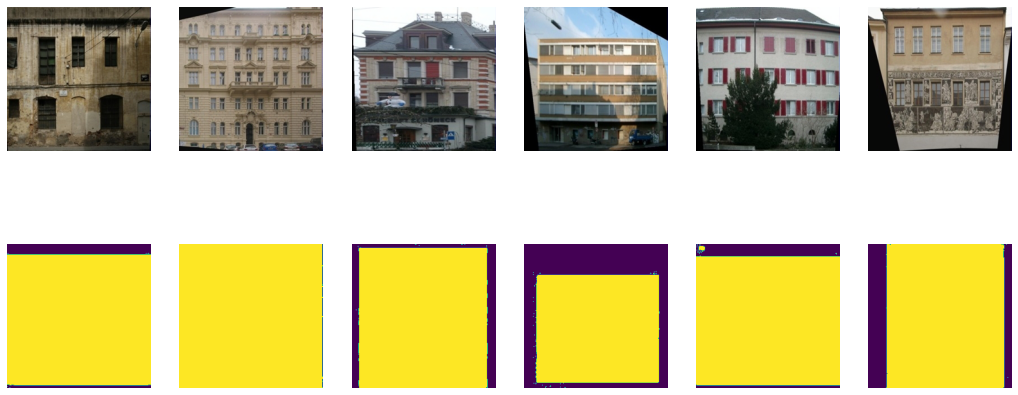

In [11]:
plt.figure(figsize=(18, 8))
for i in range(6):
    j = random.randint(0, len(train_dataset)-1)
    inp = train_dataset[j][0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(inp)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(train_dataset[j][1])
plt.show();

In [12]:
# DataLoader
batch_size = 16
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }
dataset_sizes

{'train': 320, 'val': 80}

Для данной задачи будем использовать модель UNet. Напишем её.

In [16]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                  nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                  nn.BatchNorm2d(1024),
                  nn.ReLU(),
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, kernel_size=1))

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.pool3(self.bottleneck_conv(e3))

        #decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], dim=1))
        return d3

Функция ошибки.

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()   # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))   
    union = (outputs | labels).float().sum((1, 2))  

    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

Функция потерь.

In [14]:
def bce_loss(y_real, y_pred):
    return (y_pred - (y_real * y_pred) + torch.log(1 + torch.exp(-y_pred))).sum()

Тренировочная функция.

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    best_model = model.state_dict()
    best_score = 0.0
    losses = {'train': [], "val": []}   #Здесь будем сохранять значения функции потерь для каждой эпохи.
    for epoch in trange(epochs, desc="Epoch:"):
        loss_epoch = 0
        epoch_pred = []
        epoch_true = []
        #TRAIN MODE
        model.train() 
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            loss_epoch += loss.cpu().detach().numpy()
        losses['train'].append(loss_epoch/dataset_sizes['train'])

        # TEST MODE        
        loss_epoch = 0
        model.eval()  
        for X_batch, Y_batch in data_val:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter no zero gradients 
            with torch.no_grad():
                Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss_epoch += loss.cpu().detach().numpy()
            for y_pred, y_true in zip(Y_pred.cpu().data.numpy(), Y_batch.cpu().data.numpy()):
                epoch_pred.append(y_pred)
                epoch_true.append(y_true)
        epoch_score = iou_pytorch((torch.tensor(epoch_pred)>0.5).to(device), torch.tensor(epoch_true).to(device)).mean().item()
        print(epoch_score)
        if epoch_score > best_score:
            best_score = epoch_score
            best_model = model.state_dict()
        losses['val'].append(loss_epoch/dataset_sizes['val'])
    return losses, best_model
     

Функция для сигментации на тестовых данных.

In [23]:
def predict(model, X):
    with torch.no_grad():
        model.eval()  # testing mode
        y_pred = model(X.to(device))
    return y_pred.cpu().detach().numpy()

In [24]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

        del Y_pred, Y_label, X_batch
        torch.cuda.memory.empty_cache()
    return scores/len(data)

In [21]:
model_seg = UNet().to(device)

In [22]:
max_epochs = 50
optimize = torch.optim.Adam(model_seg.parameters())
losses, best_model = train(model_seg, optimize, bce_loss, max_epochs, dataloaders['train'], dataloaders['val'])

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

0.2162499874830246
0.5637500286102295
0.6512500047683716
0.6674999594688416
0.6550000309944153
0.6362500190734863
0.6850000619888306
0.6362500190734863
0.6637500524520874
0.65625
0.6837500929832458
0.6762500405311584
0.6500000357627869
0.6512500643730164
0.7012500166893005
0.6974999904632568
0.6887500286102295
0.6300000548362732
0.6850000619888306
0.6912500262260437
0.6600000262260437
0.6875
0.6899999976158142
0.643750011920929
0.7049999833106995
0.65625
0.6774999499320984
0.6775000095367432
0.6862500309944153
0.6950000524520874
0.6825000643730164
0.6912500262260437
0.6962500214576721
0.6650000214576721
0.7087500691413879
0.690000057220459
0.7037500739097595
0.6537500619888306
0.6837500333786011
0.7075000405311584
0.6512500643730164
0.6675000190734863
0.6862500309944153
0.6825000047683716
0.6750000715255737
0.7100000381469727
0.6475000381469727
0.6812500357627869
0.6949999928474426
0.6787500381469727


Посмотрим на изменение функции потерь.

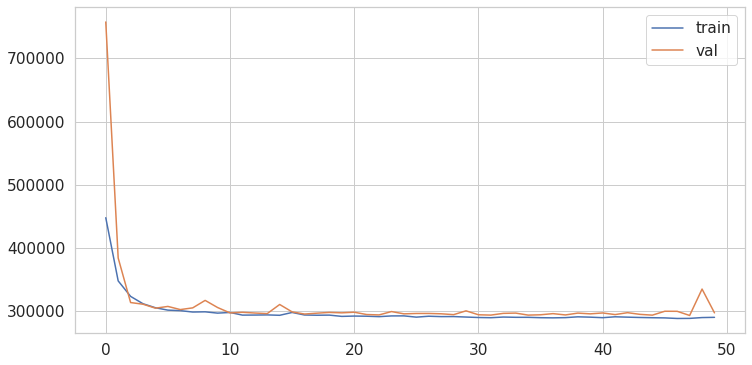

In [37]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 6))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [27]:
score_model(model_seg, iou_pytorch, dataloaders['val'])

0.6787500262260437

In [ ]:
#torch.save(model_seg.state_dict(), 'my_SegNet_20.pth')

Теперь посмотрим на то, как модель делает сегментацию.

In [28]:
test_dataset = FacadesDataset(test_images_path, test_masks_path, mode='test')

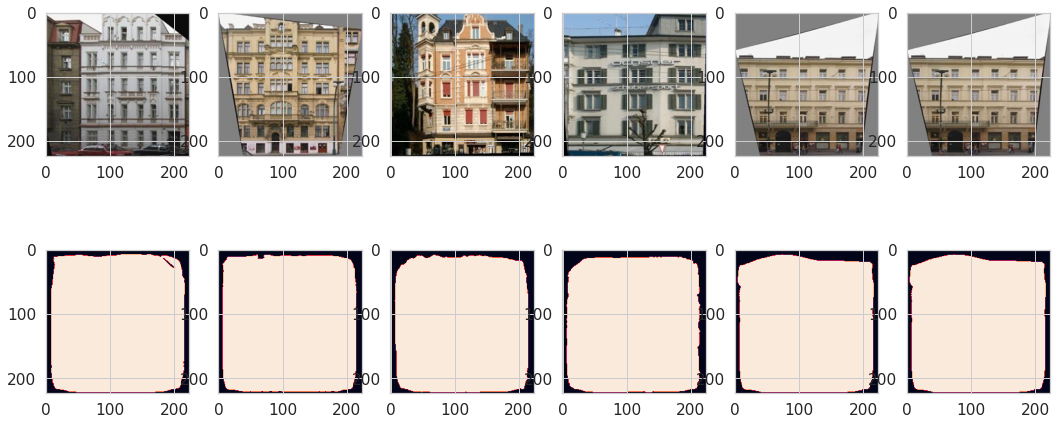

In [31]:
#Prediction
plt.figure(figsize=(18, 8))
for j in range(6):
    i = random.randint(0, len(test_dataset)-1)
    pred = predict(model_seg, test_dataset[i][None, :])[0][0]
    pred = pred > 0.5 

    inp = test_dataset[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.subplot(2, 6, j+1)
    plt.imshow(inp)
    plt.subplot(2, 6, j+7)          
    plt.imshow(pred)
plt.show();

Значение скора 0,68. Чтобы улучшить значение нужно дополнить тренировочный датасет новыми изображениями.

# Определение количества этажей.

Определим количество этажей для тренирововчный данных.

In [32]:
data = pd.read_csv('/content/facades_col.csv', delimiter=';')
data.head()

,file_name,n_col
0,1_A,4
1,2_A,6
2,3_A,6
3,4_A,4
4,5_A,5


Разобьём данные на тренировочные и тестовые. Получим пути к картинкам.

In [33]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [34]:
train_path = {}
for file_name, n_col in zip(train_data.file_name, train_data.n_col):
    train_path[f'/content/trainA/{file_name}.jpg'] = n_col

val_path = {}
for file_name, n_col in zip(val_data.file_name, val_data.n_col):
    val_path[f'/content/trainA/{file_name}.jpg'] = n_col

In [138]:
class FloorDataset(Dataset):
    def __init__(self, img_path_label, mode):
        super().__init__()
        self.mode = mode
        self.label_encoder = LabelEncoder() # Encode target labels with value between 0 and n_classes-1.

        if self.mode != 'test':
            self.img_path = list(img_path_label.keys())
            self.len_ = len(self.img_path)
            self.label = list(img_path_label.values())
            self.label_encoder.fit(self.label)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
        else:
            self.img_path = img_path_label
            self.len_ = len(self.img_path)

    def __len__(self):
        return self.len_
      
    def load_img(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                      ])
        x = self.load_img(self.img_path[index])
        x = self._prepare_img(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            y = self.label[index]
            y_id = self.label_encoder.transform([y])
            y = y_id.item()
            return x, y
   
    def _prepare_img(self, image):
        image = image.resize((new_size, new_size))
        return np.array(image)

In [128]:
train_dataset = FloorDataset(train_path, mode='train')
val_dataset = FloorDataset(val_path, mode='val')

In [116]:
label_encoder = pickle.load(open("/content/label_encoder.pkl", 'rb'))

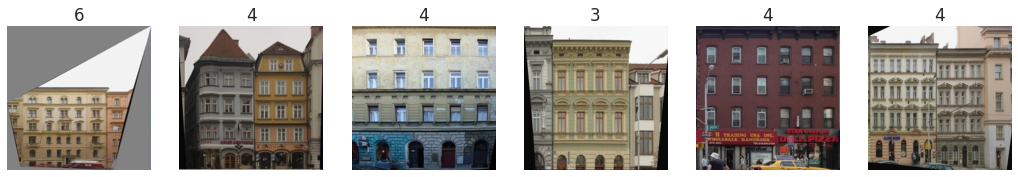

In [210]:
plt.figure(figsize=(18, 8))
for i in range(6):
    j = random.randint(0, len(train_dataset)-1)
    inp = train_dataset[j][0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(inp)
    plt.title(label_encoder.inverse_transform([train_dataset[j][1]])[0])
plt.show();


In [49]:
# DataLoader
batch_size = 32
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }
dataset_sizes

{'train': 320, 'val': 80}

In [113]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = model.state_dict()
    best_f1 = 0.0
    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")
    for epoch in pbar:
        for phase in ['train', 'val']:
            epoh_preds=[]
            epoh_labels=[]
            if phase == 'train':
              model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                if train_on_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                if phase=="train":
                    optimizer.zero_grad()
                    scheduler.step()
                    outputs = model(inputs)
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                for i,j in zip(preds.cpu().data.numpy(), labels.cpu().data.numpy()):
                    epoh_preds.append(i)
                    epoh_labels.append(j)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = f1_score(epoh_labels, epoh_preds, average='micro')
            losses[phase].append(epoch_loss)
            pbar.set_description('{} Loss: {:.4f} F1 score: {:.4f}'.format(
                                    phase, epoch_loss, epoch_f1))

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()
    print('Best val f1-score: {:4f}'.format(best_f1))
    model.load_state_dict(best_model_wts)
    return model, losses

In [93]:
def evaluate(model):
    model.eval()
    runninig_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data
        if train_on_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        runninig_correct += int(torch.sum(predicted == labels)) 
    return runninig_correct / dataset_sizes['val']

In [94]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [95]:
train_on_gpu = torch.cuda.is_available()

In [109]:
model_class = models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)

In [110]:
n_classes = data.n_col.nunique()

In [111]:
# This is the dimension of the Vector of features coming to the input of the FC layer
num_features = 512
# Replacing the Fully-Connected layer with our linear classifier
model_class.fc = nn.Linear(num_features, n_classes)

if train_on_gpu:
    model_class = model_class.cuda()

# As a cost function, we use cross-entropy
loss_fn = nn.CrossEntropyLoss()

# As an optimizer - AdamW
optimizer_ft = optim.AdamW(model_class.parameters(), lr=1e-4)

# Multiplies learning_rate by 0.1 every 10 epochs 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

In [114]:
model, losses = train_model(model_class, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch::   0%|          | 0/100 [00:00<?, ?it/s]

Best val f1-score: 0.350000


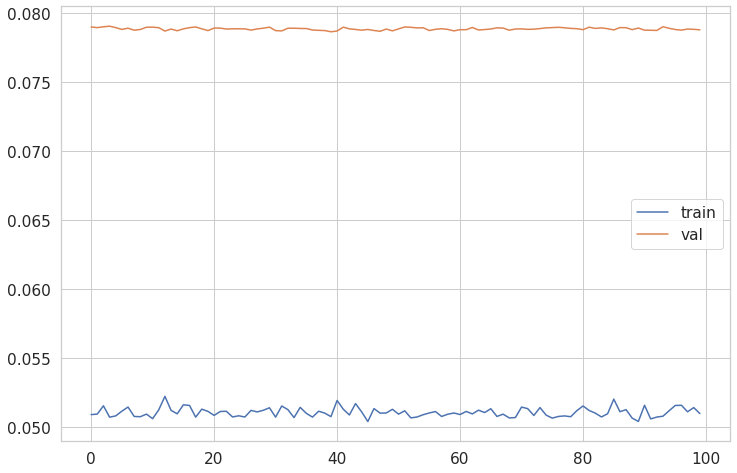

In [115]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [139]:
test_dataset = FloorDataset(test_images_path, mode='test')

In [146]:
test_loader = DataLoader(test_dataset, shuffle=False)

In [191]:
preds = predict(model, test_loader)
preds = np.argmax(preds, axis=1)

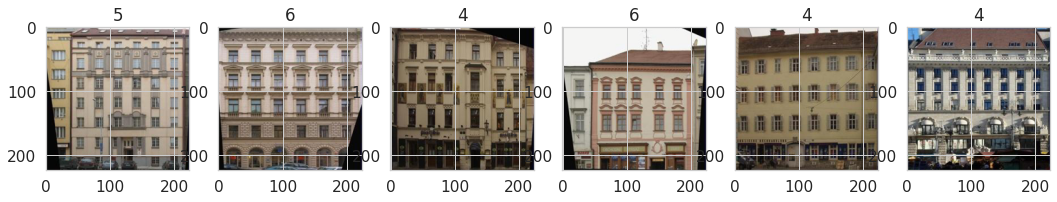

In [214]:
#Prediction
plt.figure(figsize=(18, 8))
for i in range(6):
    pred = label_encoder.inverse_transform([preds[i]])
    inp = test_dataset[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.subplot(1, 6, i+1)
    plt.imshow(inp)          
    plt.title(pred[0])
plt.show();

Для улучшение предсказаний, нужно улучшить датасет:
выбрать здания с более точным определением этажей, увеличить датасет.